# New York City Taxi Fare Prediction

In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

Fonte: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview

In [52]:
# Importando bibliotecas

# Leitura e manipulação de dados
import numpy as np
import pandas as pd
import kaggle
import math
import holidays
import time
from datetime import datetime
from geopy import distance

# Seleção de modelos
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Métricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Parâmetros importantes

# Gerando seed para replicação dos resultados
seed = np.random.seed(42)

In [3]:
# Funções criadas para facilitar o processo de análise

# Funções para verificar observações que não estão dentro do intervalo esperado para latitude e longitude
def checkLatitude(df, columns):
    dfInvalidLat = pd.DataFrame()
    for col in columns:
        dfInvalidLat = pd.concat([dfInvalidLat, df.loc[(df[col] < -90) | (df[col] > 90)]])
        print('Foram encontradas', dfInvalidLat.shape[0], 'inválidas na coluna', col)
    return dfInvalidLat

def checkLongitude(df, columns):
    dfInvalidLon = pd.DataFrame()
    for col in columns:
        dfInvalidLon = pd.concat([dfInvalidLon, df.loc[(df[col] < -180) | (df[col] > 180)]])
        print('Foram encontradas', dfInvalidLon.shape[0], 'inválidas na coluna', col)
    return dfInvalidLon


# Função para verificar observações com latitude e longitude igual a zero
def checkLatLonZero(df, columns):
    dfZero = pd.DataFrame()
    for col in columns:
        dfZero = pd.concat([dfZero, df.loc[df[col] == 0]])
        print('Foram encontradas', dfZero.shape[0], 'inválidas na coluna', col)
    return dfZero


# Removendo os valores de acordo com a medida IQR
def removeOutlierIQR(df, columns):
    lenInicial = df.shape[0]
    for col in columns:
        # Definindo quantis
        q1 = df[col].quantile(0.25)
        q2 = df[col].quantile(0.50)
        q3 = df[col].quantile(0.75)
        
        # Calculando IQR
        IQR = q3 - q1
        print('IQR para', col, IQR)

        # Mantendo apenas valores dentro do IQR
        df = df[(df[col] >= q1 - (IQR * 1.5)) & (df[col] <= q3 + (IQR * 1.5))]

        # Verificando tamanho do dataset
        print('Foram removidas', lenInicial - df.shape[0], 'devido a outliers na coluna', col)
    return df


# Calculando distancia entre dois pontos, https://geopy.readthedocs.io/en/latest/#module-geopy.distance
def calculoDistancia(partida_lat, partida_lon, chegada_lat, chegada_lon):
    origem = (partida_lat, partida_lon)
    destino = (chegada_lat, chegada_lon)
    return(distance.distance(origem, destino).km)


def verificaFeriado(year, datetime):
    feriado = holidays.CountryHoliday('US', state='NY', years = year)
    if(datetime in feriado):
        return 1
    else:
        return 0

### Obtenção dos dados

Utilizei a API do Kaggle para fazer *download* (ref. https://www.kaggle.com/docs/api).

In [4]:
# Download dos dados com API Kaggle
# ! kaggle competitions download -c new-york-city-taxi-fare-prediction
# ! unzip new-york-city-taxi-fare-prediction.zip -d train

In [5]:
# Leitura do arquivo
df = pd.read_csv('train.csv')
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [6]:
# Criando cópia para segurança do dataset
dados = df.copy()

In [7]:
# Verificando tamanho do dataset
print('Shape do dataset:\n', dados.shape, '\n')

# Verificando tipo dos dados
print('Tipo das colunas:\n', dados.dtypes)

Shape do dataset:
 (2611224, 8) 

Tipo das colunas:
 key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object


### Limpeza e tratamento dos dados

- Análise dos tipos de dados;
- Análise e tratamento de dados faltantes;
- Análise e tramento de *outliers*

#### Análise dos tipos de dados

- **pickup_datetime**: Observando a coluna 'pickup_datetime' e pela própria descrição do dataset, a coluna deveria ser no formato data. Ao tentar apenas converter, da erro por conta do 'UTC' no fim da string da data, necessário ajustar.

In [8]:
# Verificando se todas terminam com UTC
np.all(dados['pickup_datetime'].str[-3:] == 'UTC')

# Como todas as observações terminam com UTC, o fim da string será desconsiderado na conversão
dados['pickup_datetime_converted'] = dados['pickup_datetime'].apply(lambda x: datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S'))

dados.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0,2009-06-15 17:26:21
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0,2010-01-05 16:52:16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0,2011-08-18 00:35:00
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0,2012-04-21 04:30:42
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0,2010-03-09 07:51:00


In [9]:
# Removendo coluna original
dados = dados.drop(columns = ['pickup_datetime'])
dados.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009-06-15 17:26:21
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010-01-05 16:52:16
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011-08-18 00:35:00
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012-04-21 04:30:42
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010-03-09 07:51:00


- **passenger_count**: Lida como float, o ideal seria tê-la como integer. Nota-se que há tipos NaN (será tratado na etapa de tratamento de NaN) e por essa razão, a coluna foi lida como float. Após o tramento de NaNs, será realizada a conversão para int.

In [10]:
# Verificando valores únicos de passenger_count
print('Valores únicos para passenger_count', dados['passenger_count'].unique())

Valores únicos para passenger_count [  1.   2.   3.   6.   5.   4.   0. 208.   9.  nan]


#### Análise e tratamento de dados faltantes

Existem algumas observações com dados faltantes e foi optado por removê-las pois em todas as observações o local de destino está como NaN.

Alguns problemas podem ter gerado esses dados como, falha no processo de coleta de dados, erro no aplicativo que coletava os dados, etc.

In [11]:
# Verificando as linhas com NaN
dados[dados.isna().any(axis = 1)]

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted
120227,2012-12-11 12:57:00.00000013,12.50,-73.992760,40.743098,NaN,NaN,0.0,2012-12-11 12:57:00
245696,2013-03-21 18:07:07.0000001,86.50,-73.991572,40.740591,NaN,NaN,0.0,2013-03-21 18:07:07
340533,2012-12-11 12:50:52.00000010,27.50,-73.979639,40.784742,NaN,NaN,0.0,2012-12-11 12:50:52
428108,2011-09-08 09:12:52.0000001,11.80,-73.987041,40.751542,NaN,NaN,0.0,2011-09-08 09:12:52
471472,2012-12-11 12:34:20.0000006,7.80,0.000000,0.000000,NaN,NaN,0.0,2012-12-11 12:34:20
524834,2011-09-25 23:01:12.0000005,14.76,-73.985374,40.768518,NaN,NaN,0.0,2011-09-25 23:01:12
574023,2013-11-04 20:59:15.0000001,10.20,-73.998460,40.745406,NaN,NaN,0.0,2013-11-04 20:59:15
580338,2012-12-11 12:00:53.0000002,21.00,-73.974743,40.752057,NaN,NaN,0.0,2012-12-11 12:00:53
794694,2013-11-04 20:07:59.0000006,7.20,-73.977048,40.787565,NaN,NaN,0.0,2013-11-04 20:07:59
895400,2011-06-20 11:34:44.0000001,40.00,-73.862900,40.768900,NaN,NaN,0.0,2011-06-20 11:34:44


In [12]:
# Removendo as observações que contém NaN
linhas = dados.shape[0]

dados = dados.dropna()
print('Total de observações removidas com NaN:', linhas - dados.shape[0])

Total de observações removidas com NaN: 20


In [13]:
# Convertendo tipo da coluna "passenger_count" de float para int
dados['passenger_count'] = dados['passenger_count'].astype(int)

print('Tipo da coluna passenger_count:', dados['passenger_count'].dtype)
print('Valores únicos para passenger_count', dados['passenger_count'].unique())

Tipo da coluna passenger_count: int32
Valores únicos para passenger_count [  1   2   3   6   5   4   0 208   9]


#### Análise de Outliers

- Visualização de boxplots, para identificar quais colunas possuem possíveis *oultliers* de forma visual;
- Análise dos *outliers* de cada atributo;
- Remoção de *outliers* de acordo com método IQR.


<AxesSubplot:>

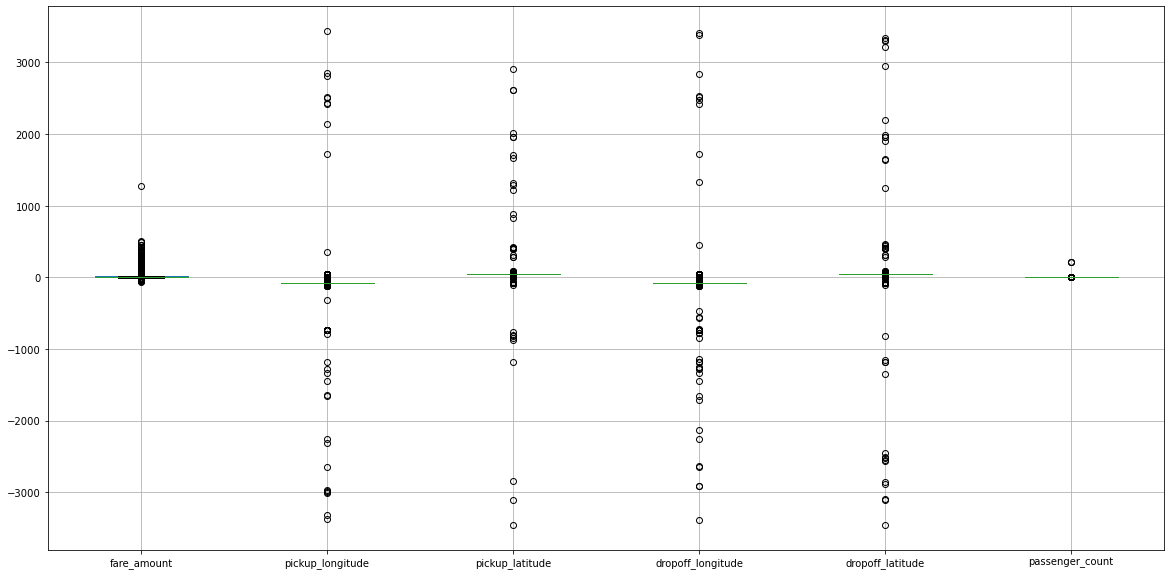

In [14]:
# Gerando boxplots
dados.boxplot(figsize = [20, 10])

In [15]:
# Verificando estatísticas das colunas
dados.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.611204e+06,2.611204e+06,2.611204e+06,2.611204e+06,2.611204e+06,2.611204e+06
mean,1.134394e+01,-7.251348e+01,3.992590e+01,-7.251513e+01,3.992230e+01,1.684325e+00
std,9.833913e+00,1.296337e+01,8.281397e+00,1.271960e+01,1.006694e+01,1.325926e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396712e+01,4.076711e+01,-7.396369e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.414307e+03,3.345917e+03,2.080000e+02


- **longitude e latitude**: nota-se tanto pelo boxplot, quanto pelas estatísticas descritivas que os valores de latitude e longitude estão ou muito acima, ou muito abaixo do esperado. As observações fora dos intervalores serão excluídas do conjunto de dados pois, são informações que a principio não há como tratar. Os valores de latitude e longitude são validos se:
 - Latitude = [-90, +90]
 - Longitude = [-180, +180]  

Para melhorar essa validação, uma vez que a base é da cidade de NY, poderia ser utilizada API do google por exemplo para verificar se as coordenadas de cada observação é válida. 

In [16]:
# Verificando Longitude
checkLongitude(dados, ['dropoff_longitude', 'pickup_longitude'])

Foram encontradas 46 inválidas na coluna dropoff_longitude
Foram encontradas 90 inválidas na coluna pickup_longitude


,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted
174356,2011-11-21 21:36:00.00000081,9.7,2140.601160,1703.092772,-1251.195890,-1189.615440,1,2011-11-21 21:36:00
269695,2012-05-24 09:00:00.000000101,17.7,-73.997572,40.720945,-1329.621332,40.773717,1,2012-05-24 09:00:00
282374,2011-04-25 13:09:00.000000123,5.7,-73.987105,40.755732,-732.600000,40.744832,1,2011-04-25 13:09:00
436233,2012-03-11 01:56:00.000000100,4.1,-2986.242495,-880.627428,-3383.296608,-2559.748913,1,2012-03-11 01:56:00
449263,2012-01-28 16:51:00.00000088,6.9,-73.983142,40.741987,-736.500000,40.755255,1,2012-01-28 16:51:00
...,...,...,...,...,...,...,...,...
2037003,2011-05-22 17:08:00.000000163,7.3,-2995.982437,-2847.702303,-1265.146753,-16.566552,1,2011-05-22 17:08:00
2326738,2011-05-22 04:58:00.00000044,4.9,2505.494292,2609.040652,2425.813367,-2892.472730,1,2011-05-22 04:58:00
2412940,2012-01-31 15:15:00.000000175,5.3,-1280.544035,2912.464657,2523.682743,1633.190122,1,2012-01-31 15:15:00
2507283,2011-11-26 17:44:00.000000103,4.5,3439.425565,882.395903,-2914.933427,-2454.875778,1,2011-11-26 17:44:00


In [17]:
# Verificando Latitude
checkLatitude(dados, ['pickup_latitude', 'dropoff_latitude'])

Foram encontradas 40 inválidas na coluna pickup_latitude
Foram encontradas 83 inválidas na coluna dropoff_latitude


,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted
5686,2011-07-30 11:15:00.00000082,3.3,-73.947235,401.083332,-73.951392,40.778927,1,2011-07-30 11:15:00
150559,2012-08-03 07:43:00.000000176,25.3,0.000000,-3116.285383,-73.953600,40.787998,1,2012-08-03 07:43:00
174356,2011-11-21 21:36:00.00000081,9.7,2140.601160,1703.092772,-1251.195890,-1189.615440,1,2011-11-21 21:36:00
272439,2011-04-23 02:55:00.00000012,9.3,-74.002497,405.350000,-73.978600,40.739962,1,2011-04-23 02:55:00
436233,2012-03-11 01:56:00.000000100,4.1,-2986.242495,-880.627428,-3383.296608,-2559.748913,1,2012-03-11 01:56:00
...,...,...,...,...,...,...,...,...
2412940,2012-01-31 15:15:00.000000175,5.3,-1280.544035,2912.464657,2523.682743,1633.190122,1,2012-01-31 15:15:00
2467350,2010-06-09 13:46:00.000000155,5.7,-73.987905,40.756362,-73.999825,468.966667,1,2010-06-09 13:46:00
2507283,2011-11-26 17:44:00.000000103,4.5,3439.425565,882.395903,-2914.933427,-2454.875778,1,2011-11-26 17:44:00
2553277,2012-05-30 21:08:00.00000066,18.9,-74.014085,40.713662,-73.955872,407.200000,1,2012-05-30 21:08:00


In [18]:
# Removendo as observações com latitude e longitude fora dos intervalos

# Verificando tamanho do dataset
print('Shape do dataset:\n', dados.shape, '\n')

dados = dados.drop(labels = checkLongitude(dados, ['dropoff_longitude', 'pickup_longitude']).index, axis = 0)
dados = dados.drop(labels = checkLongitude(dados, ['pickup_latitude', 'dropoff_latitude']).index, axis = 0)

# Verificando tamanho do dataset
print('Shape do dataset:\n', dados.shape, '\n')

Shape do dataset:
 (2611204, 8) 

Foram encontradas 46 inválidas na coluna dropoff_longitude
Foram encontradas 90 inválidas na coluna pickup_longitude
Foram encontradas 17 inválidas na coluna pickup_latitude
Foram encontradas 38 inválidas na coluna dropoff_latitude
Shape do dataset:
 (2611103, 8) 



- **passenger_count**: o boxplot mostra alguns pontos fora do esperado para a coluna de passageiro:
 - Observações com 0 serão mantidas pois, a principio pode ser entrega de algum item e não tem passageiro;
 - Observações com 208 serão removidas pois latitude e longitude estão iguais a 0;
 - Há apenas uma observações com 9 passageiros, ela será mantida pois pode ser uma van, etc.

In [19]:
# Verificando valores únicos de passageiros
dados['passenger_count'].value_counts()

1      1806446
2       385632
5       184836
3       114458
4        55516
6        54996
0         9215
208          3
9            1
Name: passenger_count, dtype: int64

In [20]:
# Verificando observações com 9 e 208
dados.loc[(dados['passenger_count'] == 9) | (dados['passenger_count'] == 208)]

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted
929022,2009-07-30 11:54:00.000000193,3.3,0.00000,0.00000,0.00000,0.00000,208,2009-07-30 11:54:00
1007609,2014-06-24 15:13:00.00000040,104.0,-74.01578,40.71542,-74.17028,40.70834,9,2014-06-24 15:13:00
2154045,2010-12-16 11:21:00.000000209,3.3,0.00000,0.00000,0.00000,0.00000,208,2010-12-16 11:21:00
2198549,2010-12-15 14:20:00.00000010,3.3,0.00000,0.00000,0.00000,0.00000,208,2010-12-15 14:20:00


In [21]:
# Removendo observações com passegeiros = 208
dados = dados.drop(labels = dados.loc[dados['passenger_count'] == 208].index, axis = 0)

- **fare_amount**: observando mais de perto essa coluna, temos valores zerados e abaixo de zero. Neste caso, também acredito que não haja muitas opções dentro das informações que temos a não ser remover essas observações. Além disso, existem valores altos de valores de corrida, podendo ser ou não problema nos dados. Irei remover utilizando o IQR (intervalo inter-quartil).


In [22]:
# Amount menor ou igual a zero 
dados.loc[dados['fare_amount'] <= 0]

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted
2039,2010-03-09 23:37:10.0000005,-2.90,-73.789450,40.643498,-73.788665,40.641952,1,2010-03-09 23:37:10
2486,2015-03-22 05:14:27.0000001,-2.50,-74.000031,40.720631,-73.999809,40.720539,1,2015-03-22 05:14:27
10002,2010-02-15 14:26:01.0000003,0.00,-73.987115,40.738808,-74.005911,40.713960,1,2010-02-15 14:26:01
13032,2013-08-30 08:57:10.0000002,-3.00,-73.995062,40.740755,-73.995885,40.741357,4,2013-08-30 08:57:10
27891,2015-05-15 21:40:28.00000010,0.00,-74.077927,40.805714,-74.077919,40.805721,1,2015-05-15 21:40:28
...,...,...,...,...,...,...,...,...
2523107,2015-04-21 22:03:31.0000005,0.00,-73.982407,40.772297,-74.029289,40.749134,1,2015-04-21 22:03:31
2540914,2015-06-15 16:39:19.0000003,-2.50,-73.973602,40.757370,-73.973434,40.757572,1,2015-06-15 16:39:19
2549777,2015-03-25 23:56:00.0000002,-53.69,0.000000,0.000000,-73.793404,40.656551,1,2015-03-25 23:56:00
2570004,2015-01-17 23:49:48.0000008,-4.00,-73.938210,40.796413,-73.943588,40.789139,1,2015-01-17 23:49:48


In [23]:
# Removendo os valores negativos e iguais a zero
dados = dados.drop(labels = (dados.loc[dados['fare_amount'] <= 0]).index, axis = 0)

# Verificando tamanho do dataset
print('Shape do dataset:\n', dados.shape, '\n')

Shape do dataset:
 (2610929, 8) 



In [24]:
# Removendo os outliers segundo o IQR
dados = removeOutlierIQR(dados, ['fare_amount'])

IQR para fare_amount 6.5
Foram removidas 224876 devido a outliers na coluna fare_amount


Como há observações com 0 nas colunas de **latitude e longitude**, importante fazer a análise desse cenário também. Há bastante linhas (aproximadamente 1% do total de observações do dataset) com **latitude e longitude zeradas**. Este local de coordenadas [0, 0] não está localizado na cidade de NY, por essa razão é necessário fazer algum tipo de tratamento. Uma possibilidade é estimar esses parâmetros a partir de outros, fazendo a previsão e preechendo essas observações. Acredito que devido a caracteristica dos atributos que temos (passageiro, valor e data/hora) não parecem bons para estimar as coordenadas de partida e chegada.

In [25]:
# Verificando observações com latitude e longitude iguais a zero
checkLatLonZero(dados, ['dropoff_longitude', 'pickup_longitude', 'pickup_latitude', 'dropoff_latitude'])

Foram encontradas 44615 inválidas na coluna dropoff_longitude
Foram encontradas 89402 inválidas na coluna pickup_longitude
Foram encontradas 134053 inválidas na coluna pickup_latitude
Foram encontradas 178544 inválidas na coluna dropoff_latitude


,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted
11,2012-12-24 11:24:00.00000098,5.5,0.0,0.0,0.0,0.0,3,2012-12-24 11:24:00
15,2013-11-23 12:57:00.000000190,5.0,0.0,0.0,0.0,0.0,1,2013-11-23 12:57:00
26,2011-02-07 20:01:00.000000114,6.5,0.0,0.0,0.0,0.0,1,2011-02-07 20:01:00
124,2013-01-17 17:22:00.00000043,8.0,0.0,0.0,0.0,0.0,2,2013-01-17 17:22:00
192,2010-09-05 17:08:00.00000092,3.7,0.0,0.0,0.0,0.0,5,2010-09-05 17:08:00
...,...,...,...,...,...,...,...,...
2611074,2015-03-25 12:09:13.0000002,15.0,0.0,0.0,0.0,0.0,1,2015-03-25 12:09:13
2611080,2009-10-30 12:14:00.000000173,12.1,0.0,0.0,0.0,0.0,1,2009-10-30 12:14:00
2611081,2011-02-02 09:06:00.0000008,8.9,0.0,0.0,0.0,0.0,1,2011-02-02 09:06:00
2611169,2011-04-16 09:20:43.0000001,3.3,0.0,0.0,0.0,0.0,1,2011-04-16 09:20:43


In [26]:
# Removendo observações com latitude e longitude zeradas
dados = dados.drop(labels = checkLatLonZero(dados, ['dropoff_longitude', 'pickup_longitude', 'pickup_latitude', 'dropoff_latitude']).index, axis = 0)

# Verificando tamanho do dataset
print('Shape do dataset:\n', dados.shape, '\n')

Foram encontradas 44615 inválidas na coluna dropoff_longitude
Foram encontradas 89402 inválidas na coluna pickup_longitude
Foram encontradas 134053 inválidas na coluna pickup_latitude
Foram encontradas 178544 inválidas na coluna dropoff_latitude
Shape do dataset:
 (2339446, 8) 



<AxesSubplot:>

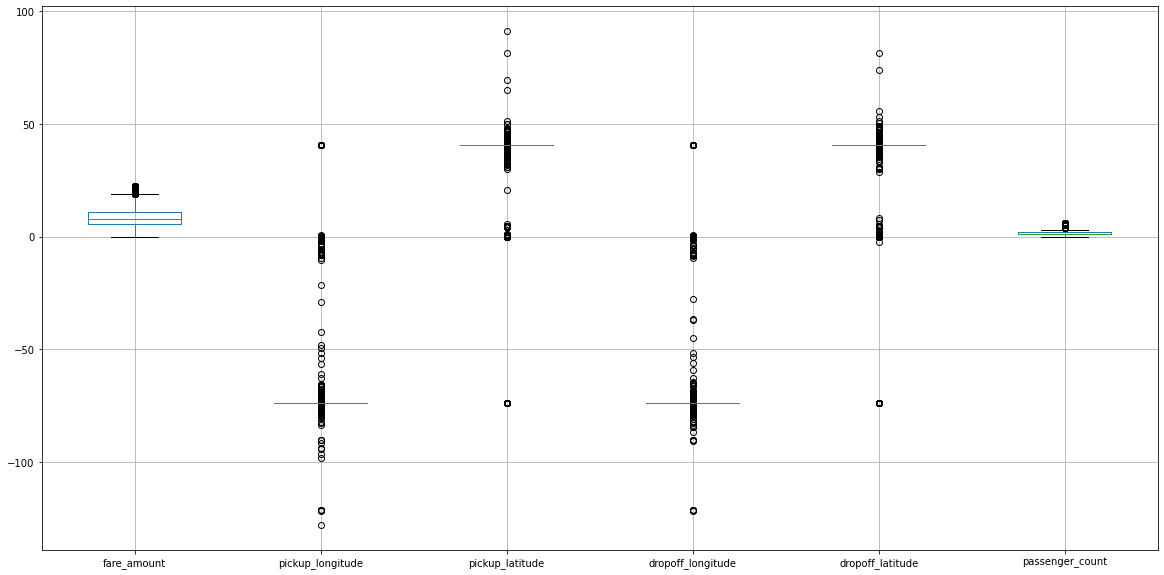

In [27]:
# Gerando boxplots após remoção de latitude e longitude zerados
dados.boxplot(figsize = [20, 10])

Ainda é possível que haja dados que precisam ser removidos ou ajustados no dataset nas colunas de latitude e longitude. Irei remover de usando o método IQR também. Outra opção seria validar as coordenadas dentro da cidade de NY ainda que com ressalvadas, pois as corridas podem ter acontecido para fora da cidade.

In [28]:
# Removendo outliers de Latitude e Longitude segundo IQR
dados = removeOutlierIQR(dados, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])

IQR para pickup_longitude 0.02239159912109301
Foram removidas 48658 devido a outliers na coluna pickup_longitude
IQR para pickup_latitude 0.029380000000003292
Foram removidas 83449 devido a outliers na coluna pickup_latitude
IQR para dropoff_longitude 0.02285600000000443
Foram removidas 119378 devido a outliers na coluna dropoff_longitude
IQR para dropoff_latitude 0.030077000000005683
Foram removidas 164660 devido a outliers na coluna dropoff_latitude


In [29]:
# Verificando tamanho do dataset
print('Shape do dataset:\n', dados.shape, '\n')

Shape do dataset:
 (2174786, 8) 



### Análise Exploratória
- Correlação entre as variáveis;
- Criação de colunas que podem ajudar a análise;
- Análise de histogramas;

#### Correlação de Pearson

Análise da correlação entre as variáveis, para ver se existe redundância de colunas ou fortes associações (positivas ou negativas). As coordenadas tem associação negativa com o preço, apesar de não serem valores muito altos.

In [30]:
# Correlação entre as variáveis
corr = dados.corr()
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,-0.058624,-0.079349,-0.022503,-0.091168,0.016145
pickup_longitude,-0.058624,1.000000,0.693927,0.408211,0.351795,-0.011377
pickup_latitude,-0.079349,0.693927,1.000000,0.333775,0.498069,-0.007504
dropoff_longitude,-0.022503,0.408211,0.333775,1.000000,0.652825,-0.010382
dropoff_latitude,-0.091168,0.351795,0.498069,0.652825,1.000000,-0.006811
passenger_count,0.016145,-0.011377,-0.007504,-0.010382,-0.006811,1.000000


#### Criação de colunas que podem ser importantes para a predição de amount

- **Distancia**: Uma opção que pode facilitar na análise é calcular a **distância** entre as coordenadas de partida e chegada. O valor não irá corresponder exatamente à distancia percorrida pelo taxi, afinal podem ter vários caminhos para chegar de um ponto ao outro mas, será uma medida aproximada que pode ajudar com a previsão. É de consenso que a distancia pode influenciar o valor de uma corrida de taxi.

In [31]:
# Criando nova coluna com base no calculo da distancia
dados['distancia'] = dados.apply(lambda x: calculoDistancia(x['pickup_latitude'], 
                                                            x['pickup_longitude'],
                                                            x['dropoff_latitude'], 
                                                            x['dropoff_longitude']), axis = 1)
 
dados.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted,distancia
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 16:52:16,8.443441
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18 00:35:00,1.389132
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 04:30:42,2.795790
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 07:51:00,1.998338
5,2011-01-06 09:50:45.0000002,12.1,-74.000964,40.731630,-73.972892,40.758233,1,2011-01-06 09:50:45,3.787980


- **Horário do dia**: os preços podem variar de acordo com o horário de acordo com o site de NY (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page#:~:text=%242.50%20initial%20charge.,Dutchess%2C%20Orange%20or%20Putnam%20Counties). Uma coluna será criada para o horário, mantendo como unidade os minutos.

In [32]:
# Criando nova coluna com os minutos do dia em que o passageiro entrou no taxi
dados['pickup_horario'] = dados['pickup_datetime_converted'].apply(lambda x: x.hour/60 + x.minute)

dados.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_converted,distancia,pickup_horario
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 16:52:16,8.443441,52.266667
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18 00:35:00,1.389132,35.000000
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 04:30:42,2.795790,30.066667
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 07:51:00,1.998338,51.116667
5,2011-01-06 09:50:45.0000002,12.1,-74.000964,40.731630,-73.972892,40.758233,1,2011-01-06 09:50:45,3.787980,50.150000


- **dia_semana** e **feriado**: No site também é falado que há diferenças quando é um dia da semana e quando é dia da semana mas também é feriado. Devido à essas informações serão utilizadas mais duas colunas: dia_semana e feriado, ambas com binárias.

In [34]:
# Criando coluna de feriado para todo o estado de NY
dados['feriado'] = dados['pickup_datetime_converted'].apply(lambda x: verificaFeriado(x.year, x))

dados['feriado'].unique()

array([0, 1], dtype=int64)

In [35]:
# Criando coluna de dia da semana ou não
dados['dia_semana'] = dados['pickup_datetime_converted'].apply(lambda x: x.weekday())

dados['dia_semana'].unique()

array([1, 3, 5, 2, 0, 6, 4], dtype=int64)

In [36]:
# Correlação após criação das novas colunas
corr = dados.corr()
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia,pickup_horario,feriado,dia_semana
fare_amount,1.000000,-0.058624,-0.079349,-0.022503,-0.091168,0.016145,0.804888,-0.005209,-0.014075,0.011022
pickup_longitude,-0.058624,1.000000,0.693927,0.408211,0.351795,-0.011377,-0.056208,-0.000969,-0.001847,-0.035004
pickup_latitude,-0.079349,0.693927,1.000000,0.333775,0.498069,-0.007504,-0.074977,0.000204,-0.000945,-0.050775
dropoff_longitude,-0.022503,0.408211,0.333775,1.000000,0.652825,-0.010382,0.018812,-0.001772,0.001469,-0.027619
dropoff_latitude,-0.091168,0.351795,0.498069,0.652825,1.000000,-0.006811,-0.033624,-0.000271,0.001147,-0.038985
passenger_count,0.016145,-0.011377,-0.007504,-0.010382,-0.006811,1.000000,0.005720,-0.000040,0.004895,0.037646
distancia,0.804888,-0.056208,-0.074977,0.018812,-0.033624,0.005720,1.000000,-0.004928,0.002178,0.034481
pickup_horario,-0.005209,-0.000969,0.000204,-0.001772,-0.000271,-0.000040,-0.004928,1.000000,0.000323,-0.002796
feriado,-0.014075,-0.001847,-0.000945,0.001469,0.001147,0.004895,0.002178,0.000323,1.000000,-0.102110
dia_semana,0.011022,-0.035004,-0.050775,-0.027619,-0.038985,0.037646,0.034481,-0.002796,-0.102110,1.000000


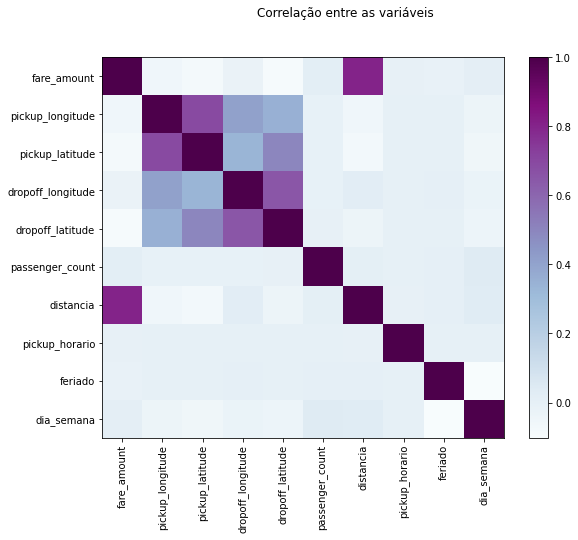

In [37]:
# Exibindo correlação com mapa de calor
plt.figure(figsize = (9, 7))
plt.imshow(corr, cmap = 'BuPu', interpolation = 'none', aspect = 'auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation = 'vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Correlação entre as variáveis', fontsize = 12)
plt.grid(False)
plt.show()

Após a criação de novas colunas, é possível ver que **distância** apareceu como um atributo com alta correlação positiva com **fare_amount**. Neste caso, como é de senso comum sabemos que de fato a distância impacta nos preços. Mas, é importante ressaltar que correlação não significa necessariamente causalidade.

#### Histogramas e distribuição

Para melhor entendimento da variável resposta, pode ser interessante analisar a distribuição dos dados. Plotando o histograma, é possível notar que aparentemente os dados não obedecem uma distribuição normal. 

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

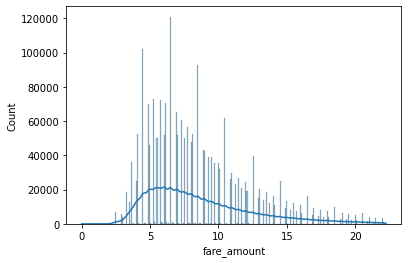

In [38]:
# Verificando o histograma da variável resposta
sns.histplot(data = dados, x = 'fare_amount', kde = True)

((array([-4.97951463, -4.8050306 , -4.71084575, ...,  4.71084575,
          4.8050306 ,  4.97951463]),
  array([1.000e-02, 1.000e-02, 1.000e-02, ..., 2.222e+01, 2.225e+01,
         2.225e+01])),
 (3.7069781050514448, 8.632690724512665, 0.960014466027335))

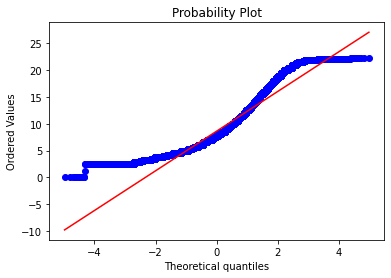

In [39]:
# Verificando quantis teóticos para a variável resposta
stats.probplot(dados['fare_amount'], plot = plt)

## Treinamento de Modelos

- Utilização de gridSearch para encontrar melhores parâmetros do RandomForest;
- Aplicação de regressão linear multipla;

#### Separando os dados

Com proporção de 80/20.


In [50]:
X = dados[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
           'dropoff_latitude', 'passenger_count', 'distancia',
           'pickup_horario', 'feriado', 'dia_semana']]

y = dados['fare_amount']

p = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = seed)

print('Tamanho treino:', x_train.shape)
print('Tamanho teste:', x_test.shape)

Tamanho treino: (1739828, 9)
Tamanho teste: (434958, 9)


#### Random Forest Regressor

Estimando parâmetros com GridSearch.

In [41]:
# Estimando os de melhores parametros com GridSearch
parametros = {
    'max_depth': range(3, 5),
    'n_estimators': (10, 50, 100),
}
gsc = GridSearchCV(estimator = RandomForestRegressor(),
                   param_grid = parametros, 
                   cv = 5, 
                   scoring = 'neg_mean_squared_error')
    
grid_result = gsc.fit(x_train, y_train)
best_params = grid_result.best_params_

print('Melhores parametros para RandomForest', best_params)

Melhores parametros para RandomForest {'max_depth': 4, 'n_estimators': 100}


In [58]:
# Criando o modelo com os os melhores parâmetros estimados segundo o o GridSearch
model_rf = RandomForestRegressor(max_depth = best_params['max_depth'],
                                 n_estimators = best_params['n_estimators'], 
                                 random_state = seed)

# Verificando tempo de execução do processamento
inicio = time.time()

model_rf.fit(x_train, y_train)

# Prevendo valores de teste
y_pred = model_rf.predict(x_test)

# Avaliação de MSE, RMSE e Coeficiente de Determinação (R2)
EQM = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

fim = time.time()
print('Duração desde da estimação até exibição dos resultados:', fim - inicio)

print('Avaliando o modelo:\n', 
      'EQM: ', EQM,
      'R2: ', r2)

Duração desde da estimação até exibição dos resultados: 459.76357793807983
Avaliando o modelo:
 EQM:  5.0570287286467375 R2:  0.6607244925164789


Importância dos atributos:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.36914058e-04
 0.00000000e+00 9.99863086e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


<BarContainer object of 9 artists>

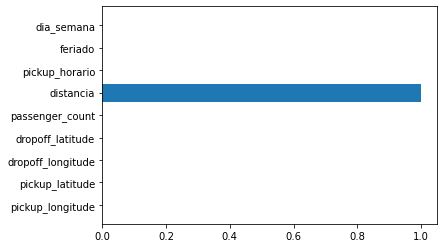

In [72]:
# Analisando os atributos mais importantes para o modelo
feature_names = dados[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
           'dropoff_latitude', 'passenger_count', 'distancia',
           'pickup_horario', 'feriado', 'dia_semana']].columns

print('Importância dos atributos: ', model_rf.feature_importances_)

plt.barh(feature_names, model_rf.feature_importances_)


#### Aplicação de Regressão Linear Multipla

In [68]:
# Utilizando todas as variáveis, inclusive a qualidade
lm = LinearRegression()
lm.fit(x_train, y_train)

y_pred_lm = lm.predict(x_test)

# Avaliando o erro quadrático médio
EQM = mean_squared_error(y_test, y_pred_lm)
print("EQM Regressão Linear Multipla:", EQM)

# Avaliando r2
R2 = r2_score(y_test, y_pred_lm)
print('R2 Regressão Linear Multipla:', R2)


EQM Regressão Linear Multipla: 5.159439578813224
R2 Regressão Linear Multipla: 0.653853759715372


<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

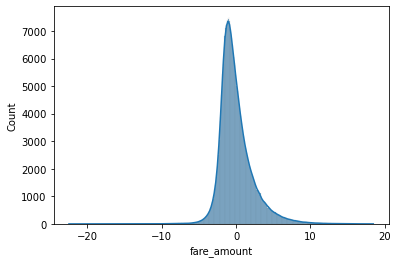

In [78]:
# Observando os resíduos, eles parecem se comprotar conforme o esperado:
# Tes uma distribuição normal com média próxima de zero
res = y_test - y_pred_lm
sns.histplot(data = res,  kde = True)


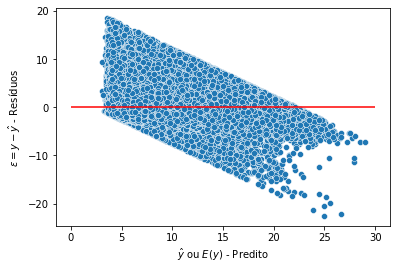

In [82]:
# Dispersão dos resíduos
sns.scatterplot(y = res, x = y_pred_lm)

plt.hlines(y = 0, xmin = 0, xmax = 30, color = 'red')
plt.ylabel('$\epsilon = y - \hat{y}$ - Resíduos')
plt.xlabel('$\hat{y}$ ou $E(y)$ - Predito')
plt.show()

In [87]:
# Correlação entre o y e y predito
# Espero que não haja nenhuma

corr_y = pd.Series(res).corr(pd.Series(y_pred_lm))
print('Correlação entre resíduos e y predito', corr_y)

Correlação entre resíduos e y predito -0.0026554494900333284
